In [1]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions

# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.11 ; cuda:  1.11.0


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import os
import cv2
from detectron2.structures import BoxMode
import mots_utils

# import some common libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, json, cv2, random
from matplotlib.pyplot import imshow as cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

import PIL.Image as Image
import numpy as np
import pycocotools.mask as rletools
import glob

"""def cv2_imshow():
    plt.imshow(cv2.cvtColor())"""

plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
def detector(im):
    cfg = get_cfg()
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)

    # look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
    """    print(outputs["instances"].pred_classes)
    print(outputs["instances"].pred_boxes)"""

    # We can use `Visualizer` to draw the predictions on the image.
    viz = Visualizer(im2[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = viz.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [4]:
# We can use `Visualizer` to draw the predictions on the image.
"""im2 = cv2.imread("W2/input6.jpg")
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.show()
detector(im2)"""

'im2 = cv2.imread("W2/input6.jpg")\nplt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))\nplt.show()\ndetector(im2)'

In [5]:
class SegmentedObject:
  def __init__(self, mask, class_id, track_id):
    self.mask = mask
    self.class_id = class_id
    self.track_id = track_id

def load_txt(path):
  objects_per_frame = {}
  track_ids_per_frame = {}  # To check that no frame contains two objects with same id
  combined_mask_per_frame = {}  # To check that no frame contains overlapping masks
  with open(path, "r") as f:
    for line in f:
      line = line.strip()
      fields = line.split(" ")

      frame = int(fields[0])
      if frame not in objects_per_frame:
        objects_per_frame[frame] = []
      if frame not in track_ids_per_frame:
        track_ids_per_frame[frame] = set()
      if int(fields[1]) in track_ids_per_frame[frame]:
        assert False, "Multiple objects with track id " + fields[1] + " in frame " + fields[0]
      else:
        track_ids_per_frame[frame].add(int(fields[1]))

      class_id = int(fields[2])
      if not(class_id == 1 or class_id == 2 or class_id == 10):
        assert False, "Unknown object class " + fields[2]

      mask = {'size': [int(fields[3]), int(fields[4])], 'counts': fields[5].encode(encoding='UTF-8')}
      if frame not in combined_mask_per_frame:
        combined_mask_per_frame[frame] = mask
      elif rletools.area(rletools.merge([combined_mask_per_frame[frame], mask], intersect=True)) > 0.0:
        assert False, "Objects with overlapping masks in frame " + fields[0]
      else:
        combined_mask_per_frame[frame] = rletools.merge([combined_mask_per_frame[frame], mask], intersect=False)
      objects_per_frame[frame].append(SegmentedObject(
        mask,
        class_id,
        int(fields[1])
      ))

  return objects_per_frame

TRAINING

In [6]:
DATASET_PATH = 'KITTI'

TRAINING_SEQ = ["0011","0017","0009","0020","0019","0005","0000","0015","0001", "0004" , "0003" , "0012"]
TESTING_SEQ = ["0002","0006" ,"0007" ,"0008" ,"0010" ,"0013" ,"0014" ,"0016" ,"0018"]


CLASSES = [
    'Cars','Pedestrian'
    ]
CLASSES_MAP = {1:0,2:1}

def get_dataset_files(dataset_path, type_seq):
    sequence_map = {
        "train": TRAINING_SEQ,
        "test": TESTING_SEQ
    }
    sequence = sequence_map[type_seq]
    image_paths = []
    instances_path = []

    for seq in sequence:
        image_paths.append(os.path.join(dataset_path, "training\\image_02", seq))
        instances_path.append(os.path.join(dataset_path, 'instances_txt', seq + '.txt'))

    image_folders = sorted(image_paths)
    instances_txts = sorted(instances_path)
    return [(folder,txt) for folder,txt in zip(image_folders, instances_txts)]

def get_dataset_dicts(dataset_path, type_seq):
    dataset_dicts = []
    for train_folder, train_txt in get_dataset_files(dataset_path, type_seq):
        # get data folder and its corresponding txt file
        # load the annotations for the folder
        annotations = load_txt(train_txt)
        image_paths = sorted(os.listdir(train_folder))
        for indx, (image_path, (file_id, objects)) in enumerate(zip(image_paths, list(annotations.items()))):
            #check the file is png or jpg
            if image_path.split('.')[1] in ['png','jpg']:
                record = {}

                filename = os.path.join(train_folder, image_path)
                height,width = cv2.imread(filename).shape[:2]

                record["file_name"] = filename
                record["image_id"] = filename
                record["height"] = height
                record["width"] = width

                objs = []
                for obj in objects:
                    if obj.track_id != 10000:
                        category_id = obj.class_id    
                        bbox = rletools.toBbox(obj.mask)
                        obj_dic = {
                            "bbox" : list(bbox),
                            "bbox_mode" : BoxMode.XYWH_ABS,
                            "category_id" : CLASSES_MAP[category_id]
                        }
                        objs.append(obj_dic)

                record["annotations"] = objs
                dataset_dicts.append(record)
    ###print(dataset_dicts)
    return dataset_dicts


DatasetCatalog.clear()
MetadataCatalog.clear()
for d in ['train', 'test']:
    DatasetCatalog.register("kitti_" + d, lambda d= d: get_dataset_dicts(DATASET_PATH, d))
    MetadataCatalog.get("kitti_" + d).set(thing_classes=CLASSES)


kitti_metadata = MetadataCatalog.get("kitti_train")
dataset_dicts = get_dataset_dicts(DATASET_PATH, "train")

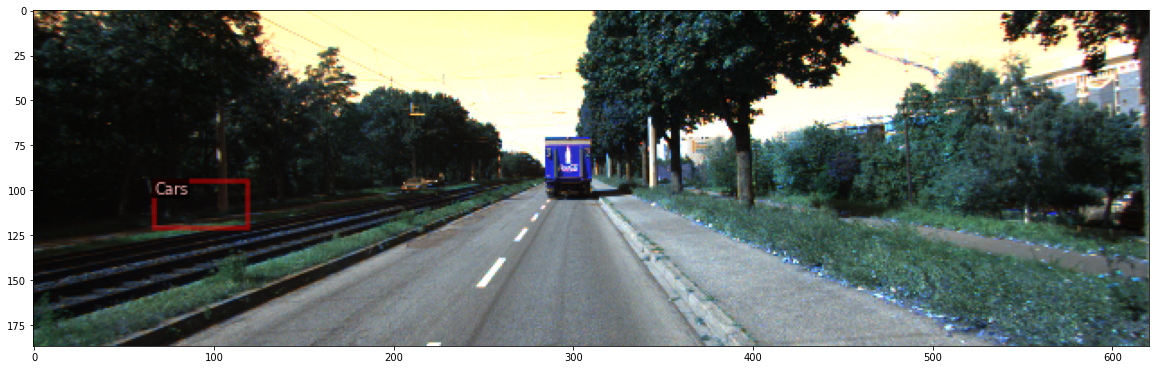

In [7]:

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    cv2_imshow(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=kitti_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [8]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("kitti_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/20 23:30:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[03/20 23:31:16 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\carla\anaconda3\envs\detectron2\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/20 23:31:39 d2.utils.events]:  eta: 0:27:20  iter: 19  total_loss: 2.049  loss_cls: 1.088  loss_box_reg: 0.8485  loss_rpn_cls: 0.08242  loss_rpn_loc: 0.03453  time: 0.8307  data_time: 0.1757  lr: 4.9953e-06  max_mem: 5815M
[03/20 23:31:56 d2.utils.events]:  eta: 0:27:19  iter: 39  total_loss: 2.044  loss_cls: 1.046  loss_box_reg: 0.8862  loss_rpn_cls: 0.07515  loss_rpn_loc: 0.02844  time: 0.8343  data_time: 0.0565  lr: 9.9902e-06  max_mem: 5815M
[03/20 23:32:12 d2.utils.events]:  eta: 0:27:05  iter: 59  total_loss: 1.915  loss_cls: 0.9404  loss_box_reg: 0.8609  loss_rpn_cls: 0.08457  loss_rpn_loc: 0.0363  time: 0.8363  data_time: 0.0562  lr: 1.4985e-05  max_mem: 5815M
[03/20 23:32:29 d2.utils.events]:  eta: 0:26:52  iter: 79  total_loss: 1.796  loss_cls: 0.8356  loss_box_reg: 0.8609  loss_rpn_cls: 0.06106  loss_rpn_loc: 0.02983  time: 0.8383  data_time: 0.0560  lr: 1.998e-05  max_mem: 5815M
[03/20 23:32:46 d2.utils.events]:  eta: 0:26:37  iter: 99  total_loss: 1.653  loss_cls: 0.70

In [9]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 8396), started 9:04:03 ago. (Use '!kill 8396' to kill it.)

INFERENCE

In [28]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

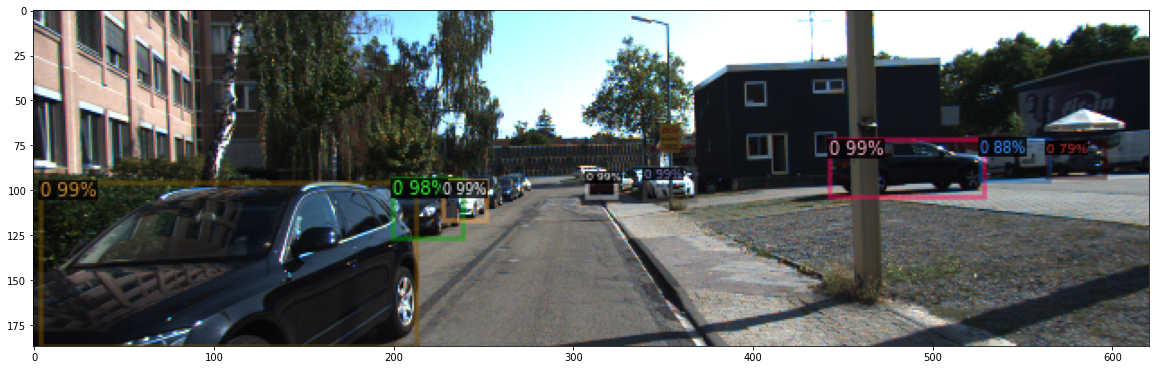

In [37]:
from detectron2.utils.visualizer import ColorMode
#dataset_dicts = get_dataset_dicts(DATASET_PATH, "test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata={}, 
                   scale=0.5, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01  # set the testing threshold for this model

### MAP #####
#We can also evaluate its performance using AP metric implemented in COCO API.
evaluator = COCOEvaluator('kitti_test', cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'kitti_test')
print('---------------------------------------------------------')
print('AAA')
print(inference_on_dataset(trainer.model, val_loader, evaluator))
print('---------------------------------------------------------')

WARNING [03/21 00:00:24 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/21 00:00:24 d2.evaluation.coco_evaluation]: Trying to convert 'kitti_test' to COCO format ...
WARNING [03/21 00:00:24 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output\kitti_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[03/21 00:00:50 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    Cars    | 8029         | Pedestrian | 3347         |
|            |              |            |              |
|   total    | 11376        |            |              |
[03/21 00:00:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333